# Hierarchical Clustering (dendograms)

https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8

https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp

https://copyprogramming.com/howto/finding-clusters-in-multidimensional-data

In [1]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import DecisionTreeRegressor

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# common visualization module
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

# numeric library
import numpy as np

import os
import pandas as pd
from time import time as timer
import tarfile

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering


In [2]:
#Import the two cleaned datasets
# dataset with the threshold
file_path = 'C:/Users/Gaëlle/Documents/_CAS applied data science/3. Module 3 Data analysis and machine learning/Project/Models/final_GMA.csv'
df_01 = pd.read_csv(file_path)


In [3]:
column_names=df_01.columns.tolist()    
#column_names

## Standardization

=> It is important to standardize the data, especially when dealing with models related to distances.

In [4]:
scaler = StandardScaler()
df_0 = df_01.drop(columns=['name_hosp'])
df = scaler.fit_transform(df_0)

In [5]:
df.shape

(298, 468)

## Dendrogram

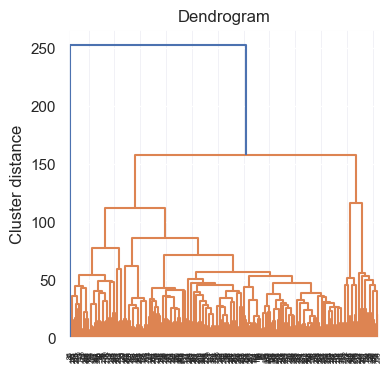

In [6]:
Z = hierarchy.linkage(df, method='ward')

plt.figure(figsize=(4, 4))
d = hierarchy.dendrogram(Z)
plt.title("Dendrogram")
plt.ylabel("Cluster distance")
plt.show()

#### Interpretation of the Dendrogram:
Vertical Axes: The vertical axes represent samples or groups of samples.

Lengths of Horizontal Lines: The length of the horizontal lines indicates the "distance" between the groups. The longer the line, the greater the distance between the groups.

Height of the Dendrogram: The height at which two branches join represents the distance at which the groups were merged.

### Dendrogram with a threshold, as an illustration

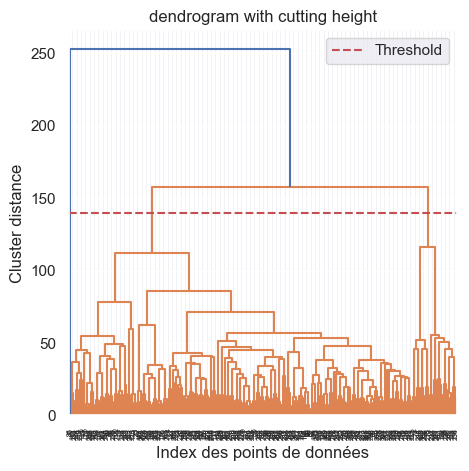

In [7]:
Z = hierarchy.linkage(df, method='ward')
plt.figure(figsize=(5, 5))
d = hierarchy.dendrogram(Z)

# Add a horizontal line to represent the cutting height
plt.axhline(y=140, color='r', linestyle='--', label='Threshold') # We can choose another cutting height!

plt.title("dendrogram with cutting height")
plt.ylabel("Cluster distance")
plt.xlabel("Index des points de données")
plt.legend()

plt.show()

### How many clusters should we define?

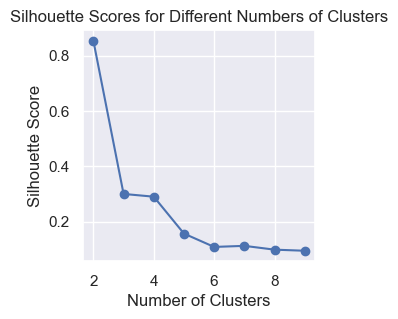

In [8]:
### Silouette score

max_clusters=10 # max cluster is set to 10
method='ward'
silhouette_scores=[]

for n_clusters in range(2, max_clusters):   
# Perform agglomerative clustering
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage=method).fit_predict(df)
        
# Calculate silhouette score
    silhouette_avg = silhouette_score(df, labels)
    silhouette_scores.append(silhouette_avg)
    
# Plot silhouette scores
plt.figure(figsize=(3, 3))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

The silhouette score is highest when there are two cluster assignments. However, if we select only 2 clusters it looks like one observation will be in one cluster and all the other observations will be in the other cluters. 
It would then make more sense to take 3 or 4 clusters.

=> Shall we delete this observation which seems to be very different from the others?

In [9]:
## Assign each observation to one of the three clusters

In [10]:
Z = hierarchy.linkage(df, method='ward')

# Set up the number of observations
num_clusters = 3

# use fcluster to assign cluster
labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# New column nammed 'Cluster'
# back to a DataFrame
df_1 = pd.DataFrame(df, columns=df_0.columns)
df_1['Cluster'] = labels

In [11]:
## Check that we have the right number of clusers and the number of observations per cluster
unique = df_1['Cluster'].unique()
print(unique)

nb = df_1['Cluster'].value_counts()
print(nb)

[1 2 3]
Cluster
1    262
2     35
3      1
Name: count, dtype: int64


### Let's try to visualize the c-section rate and another variable, with the observerations being colored by their cluster

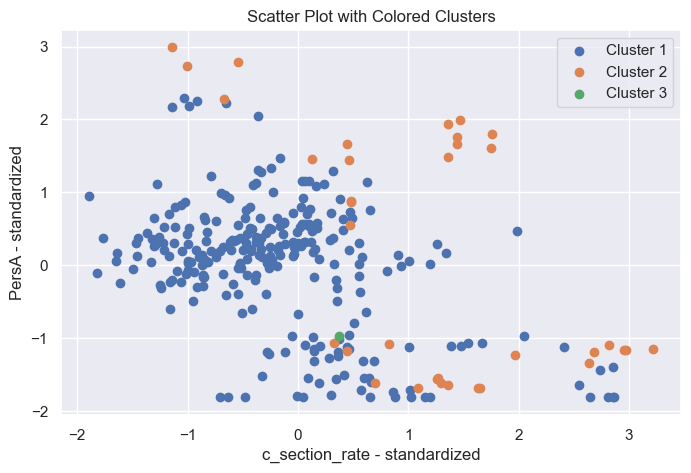

In [12]:
plt.figure(figsize=(8, 5))
for cluster in range(1, num_clusters + 1):
    cluster_data = df_1[df_1['Cluster'] == cluster]
    plt.scatter(cluster_data['c_section_rate'], cluster_data['PersA'], label=f'Cluster {cluster}')

plt.title("Scatter Plot with Colored Clusters")
plt.xlabel("c_section_rate - standardized")
plt.ylabel("PersA - standardized")
plt.legend()
plt.show()

=> there is only one observation in the cluster number 3, probably an outlier.

### Side note: what is this outlier?

In [13]:
df_01['Cluster'] = labels

In [14]:
outlier = df_01[df_01['Cluster'] == 3]

In [15]:
outlier

,name_hosp,c_section_rate,I.1.16.M,A.5.1.F,A.7.14.M,L.6.4.F,KostAWLFA,L.5.5.F,A.7.1.F,D.2.6.P,...,"SA_MRI, CT, PET, Angio, Dia","SA_MRI, CT, PET, CC, Angio","SA_MRI, CT, PET, CC, Angio, Dia","SA_MRI, CT, PET, CC, LB, Angio","SA_MRI, CT, PET, CC, LB, Angio, Dia","SA_MRI, CT, PET, CC, LB, Dia","SA_MRI, CT, PET, CC, LB, Lito, Angio","SA_MRI, CT, PET, CC, LB, Lito, Angio, Dia","SA_MRI, CT, PET, CC, Lito, Angio, Dia",Cluster
98,Hirslanden Klinik St. Anna AG Hirslanden Klini...,0.363276,1.731752,8.32573,0.0,0.0,0.0,0.0,1.665146,1.198905,...,False,False,False,False,False,False,False,False,False,3


## Without the outlier

In [16]:
# Delete observation belonging to cluster 3
df_2 = df_1[df_1['Cluster'] != 3]

In [17]:
print(df_0.shape) # data imported
print(df.shape) # array standardized
print(df_1.shape) # dataframe (standardized) with the variable cluster
print(df_2.shape) # dataframe (standardized) with the variable cluster but without the outlier

(298, 468)
(298, 468)
(298, 469)
(297, 469)


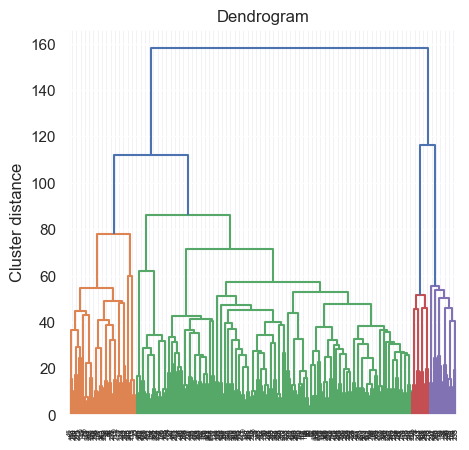

In [18]:
Z = hierarchy.linkage(df_2, method='ward')

plt.figure(figsize=(5, 5))
d = hierarchy.dendrogram(Z)
plt.title("Dendrogram")
plt.ylabel("Cluster distance")
plt.show()

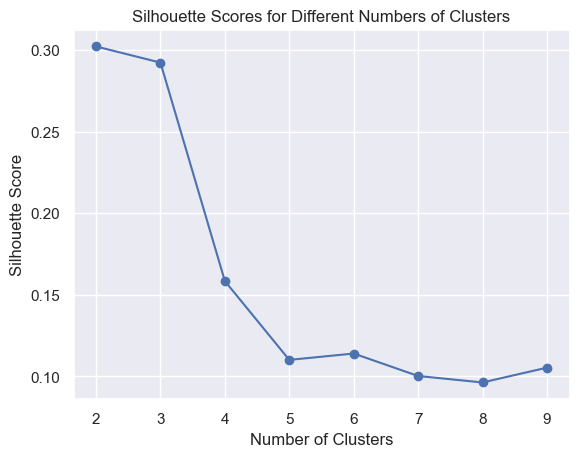

In [19]:
### Silouette score
max_clusters=10 # max cluster is set to 10
method='ward'
silhouette_scores=[]

for n_clusters in range(2, max_clusters):   
# Perform agglomerative clustering
    labels = AgglomerativeClustering(n_clusters=n_clusters, linkage=method).fit_predict(df_2)
        
# Calculate silhouette score
    silhouette_avg = silhouette_score(df_2, labels)
    silhouette_scores.append(silhouette_avg)
    
# Plot silhouette scores
plt.plot(range(2, max_clusters), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

#### => let's create 4 clusters

In [20]:
# Set up the number of observations
num_clusters = 4

In [21]:
Z = hierarchy.linkage(df_2, method='ward')

# use fcluster to assign cluster
labels = fcluster(Z, t=num_clusters, criterion='maxclust')

# New column nammed 'Cluster'
# back to a DataFrame
df_3 = pd.DataFrame(df_2, columns=df_0.columns)
df_3['Cluster'] = labels

## Check that we have two clusers and how many observations per cluster
unique = df_3['Cluster'].unique()
print(unique)

nb = df_3['Cluster'].value_counts()
print(nb)

[1 3 2 4]
Cluster
2    211
1     51
4     21
3     14
Name: count, dtype: int64


### C-section rate and clusters

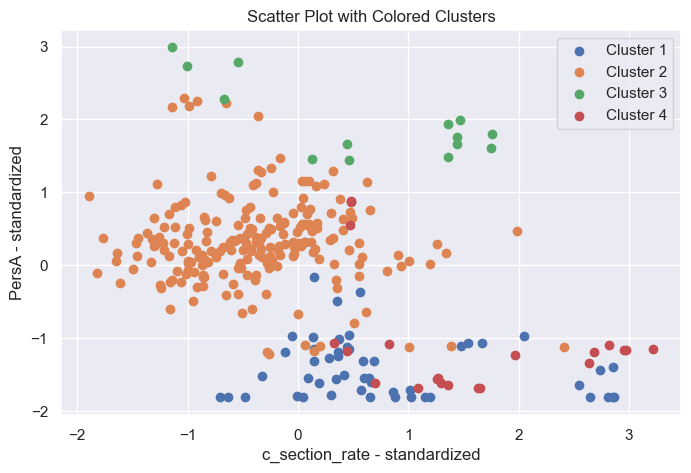

In [22]:
plt.figure(figsize=(8, 5))
for cluster in range(1, num_clusters + 1):
    cluster_data = df_3[df_3['Cluster'] == cluster]
    plt.scatter(cluster_data['c_section_rate'], cluster_data['PersA'], label=f'Cluster {cluster}')

plt.title("Scatter Plot with Colored Clusters")
plt.xlabel("c_section_rate - standardized")
plt.ylabel("PersA - standardized")
plt.legend()
plt.show()

### C-section rate distribution per cluster

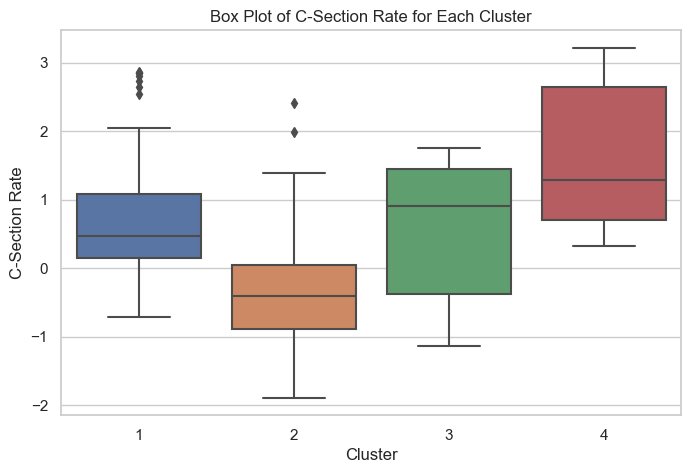

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a box plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Cluster', y='c_section_rate', data=df_3)

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('C-Section Rate')
plt.title('Box Plot of C-Section Rate for Each Cluster')

plt.savefig("box_plot_hierarchical clustering.png")
plt.show()